## Load libraries

In [1]:
# Libraries to work with dataset
import pandas as pd

# Libraries to preprocess text

# Libraries to cluster data

# Libraries to visualize data
import seaborn as sns

## Import data

In [2]:
BASE_DIR = "E:/THIENDHB_GOOGLEDRIVE/MASTER TILBURG/THESIS/DATASET/"

df = pd.read_csv(BASE_DIR + "refined_jobpost_data.csv")

In [3]:
df.shape

(18992, 5)

In [4]:
df.head()

,job_id,job_title,job_description,job_requirement,job_qualification
0,1,Chief Financial Officer,AMERIA Investment Consulting Company is seekin...,- Supervises financial management and administ...,"To perform this job successfully, an\r\nindivi..."
1,2,Full-time Community Connections Intern (paid i...,IREX currently seeks to fill the position of a...,- Presenting the CC program to interested part...,- Bachelor's Degree; Master's is preferred;\r\...
2,3,Country Coordinator,Public outreach and strengthening of a growing...,- Working with the Country Director to provide...,"- Degree in environmentally related field, or ..."
3,4,BCC Specialist,The LEAD (Local Enhancement and Development fo...,- Identify gaps in knowledge and overseeing in...,"- Advanced degree in public health, social sci..."
4,5,Software Developer,NaN,- Rendering technical assistance to Database M...,- University degree; economical background is ...


In [5]:
df.columns

Index(['job_id', 'job_title', 'job_description', 'job_requirement',
       'job_qualification'],
      dtype='object')

In [6]:
def missing_values_table(df):
   
    # Total missing values
    mis_val = df.isnull().sum()
    
    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    
    # Rename the columns
    mis_val_table_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    
    # Sort the table by percentage of missing descending
    # .iloc[:, 1]!= 0: filter on missing missing values not equal to zero
    mis_val_table_columns = mis_val_table_columns[
        mis_val_table_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(2)  # round(2), keep 2 digits
    # Print some summary information
    print("Dataset has {} columns.".format(df.shape[1]) + '\n' + 
    "There are {} columns that have missing values.".format(mis_val_table_columns.shape[0]))
    
    # Return the dataframe with missing information
    return mis_val_table_columns

In [7]:
missing_values_table(df)

Dataset has 5 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values
job_description,3411,17.96
job_requirement,2508,13.21
job_qualification,472,2.49


<AxesSubplot:>

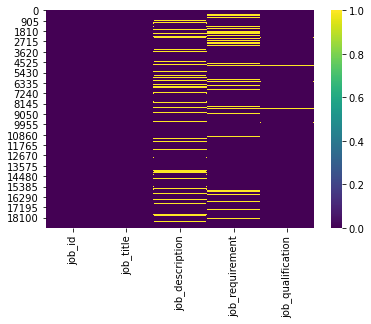

In [8]:
sns.heatmap(df.isnull(), cmap='viridis')

## Text preprocessing

- Removing URL
- Lowercasing
- Removing irrelevant characters (punctuation, numbers)
- Tokenization
- Removing stopwords
- Lemmatization

In [9]:
# Removing URL
df["clean_qualification"] = (
    df["job_qualification"]
    .replace(r"http\S+", "", regex=True)
    .replace(r"www\S+", "", regex=True)
)

In [10]:
df["clean_qualification"][1:10]

1    - Bachelor's Degree; Master's is preferred;\r\...
2    - Degree in environmentally related field, or ...
3    - Advanced degree in public health, social sci...
4    - University degree; economical background is ...
5    - Candidates should be female, 20-30 years old...
6    - University degree in finance/ accounting; \r...
7                                                  NaN
8    - University degree;\r\n- At least 3 years of ...
9    NOTE: All applicants are instructed to\r\naddr...
Name: clean_qualification, dtype: object

In [11]:
# Lowercasing
df['clean_qualification'] = df['clean_qualification'].str.lower()

In [12]:
df["clean_qualification"][1:10]

1    - bachelor's degree; master's is preferred;\r\...
2    - degree in environmentally related field, or ...
3    - advanced degree in public health, social sci...
4    - university degree; economical background is ...
5    - candidates should be female, 20-30 years old...
6    - university degree in finance/ accounting; \r...
7                                                  NaN
8    - university degree;\r\n- at least 3 years of ...
9    note: all applicants are instructed to\r\naddr...
Name: clean_qualification, dtype: object

In [14]:
import string

# Removing special characters
spec_chars = string.punctuation #+ string.digits
print(spec_chars)
spec_chars = [char for char in spec_chars]
for char in spec_chars:
    df['clean_qualification'] = df['clean_qualification'].str.replace(char, ' ')

df['clean_qualification'] = df['clean_qualification'].str.split().str.join(" ")

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [15]:
df["clean_qualification"][1:10]

1    bachelor s degree master s is preferred excell...
2    degree in environmentally related field or 5 y...
3    advanced degree in public health social scienc...
4    university degree economical background is a p...
5    candidates should be female 20 30 years old ni...
6    university degree in finance accounting one ye...
7                                                  NaN
8    university degree at least 3 years of experien...
9    note all applicants are instructed to address ...
Name: clean_qualification, dtype: object

In [18]:
from nltk.corpus import stopwords

# Remove stop words:
# nltk.download('stopwords')
STOPWORDS = set(stopwords.words("english"))
# print(list(STOPWORDS)[0:10])


def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])


df["clean_qualification"] = df["clean_qualification"].apply(lambda text: remove_stopwords(text))
df["clean_qualification"][1:10]

1    bachelor degree master preferred excellent ski...
2    degree environmentally related field 5 years r...
3    advanced degree public health social science c...
4    university degree economical background plus e...
5    candidates female 20 30 years old nice looking...
6    university degree finance accounting one year ...
7                                                  nan
8    university degree least 3 years experience rel...
9    note applicants instructed address selection c...
Name: clean_qualification, dtype: object

In [19]:
# Lemmatization
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
# nltk.download('punkt')

lemmatizer = WordNetLemmatizer()

# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

df["clean_qualification"] = df["clean_qualification"].apply(lambda text: lemmatize_sentence(text))
df["clean_qualification"][1:10]

1    bachelor degree master prefer excellent skill ...
2    degree environmentally related field 5 year re...
3    advanced degree public health social science c...
4    university degree economical background plus e...
5    candidate female 20 30 year old nice look exte...
6    university degree finance accounting one year ...
7                                                  nan
8    university degree least 3 year experience rele...
9    note applicant instruct address selection crit...
Name: clean_qualification, dtype: object

In [20]:
df['job_qualification'][2]

'- Degree in environmentally related field, or 5 years relevant\r\nexperience;\r\n- Oral and written fluency in Armenian, Russian and English;\r\n- Knowledge/ experience of working with environmental issues specific to\r\nArmenia is a plus.\r\nREMUNERATION:  Salary commensurate with experience.'

In [21]:
df['clean_qualification'][2]

'degree environmentally related field 5 year relevant experience oral write fluency armenian russian english knowledge experience work environmental issue specific armenia plus remuneration salary commensurate experience'

## Feature selection

## Clustering

In [ ]:
# from sklearn.feature_extraction.text import TfidfVectorizer

# vectorizer = TfidfVectorizer(stop_words={"english"})
# X = vectorizer.fit_transform(df["clean_qualification"])

In [ ]:
# import matplotlib.pyplot as plt
# from sklearn.cluster import KMeans

# Sum_of_squared_distances = []
# K = range(2, 10)
# for k in K:
#     km = KMeans(n_clusters=k, max_iter=200, n_init=10)
#     km = km.fit(X)
#     Sum_of_squared_distances.append(km.inertia_)
# plt.plot(K, Sum_of_squared_distances, "bx-")
# plt.xlabel("k")
# plt.ylabel("Sum_of_squared_distances")
# plt.title("Elbow Method For Optimal k")
# plt.show()